<h1>Import Required Libraries<h1>
<p>This section loads all the essential libraries used for environment setup, numerical operations, and visualization.<p>


In [27]:
import gymnasium as gym  # Import the Gymnasium library for reinforcement learning environments
import numpy as np       # Import NumPy for numerical operations
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import seaborn as sns    # Import Seaborn for better visualization aesthetics

<h1>Environment Setup with Custom FrozenLake Map<h1>
<p>This section defines a custom 4x4 map layout and initializes the FrozenLake-v1 environment using Gymnasium.<p>


In [28]:
# Define a custom 4x4 map layout for the FrozenLake environment
desc = [
    # S = Start, F = Frozen (safe), H = Hole (you fall in and lose), G = Goal
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

# Create the FrozenLake environment with the custom map
# is_slippery=True means there's a chance the agent may slip to the side
env = gym.make('FrozenLake-v1', desc=desc, map_name="4x4", is_slippery=True)

# Access the raw environment to bypass any wrappers (for full control)
env = env.unwrapped


<h1>Value Iteration Algorithm<h1>
<p>This section implements the core value iteration algorithm to compute the optimal value function and policy for the FrozenLake environment.
<p>


In [29]:
def value_iteration(env, gamma=1.0, theta=1e-8):
    # Get the number of states and actions from the environment
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Initialize the value function for all states to zero
    V = np.zeros(n_states)

    # Initialize a policy as a one-hot vector for each state (to be filled later)
    policy = np.zeros((n_states, n_actions))

    iteration = 0  # Counter to keep track of how many iterations it takes

    # Begin Value Iteration loop
    while True:
        delta = 0  # Tracks the maximum change in value function across states
        for s in range(n_states):
            q_sa = np.zeros(n_actions)  # To store Q-values for each action at state s
            for a in range(n_actions):
                # Loop over all possible outcomes for taking action 'a' at state 's'
                for prob, next_state, reward, done in env.P[s][a]:
                    q_sa[a] += prob * (reward + gamma * V[next_state])
            max_q = np.max(q_sa)  # Best Q-value for this state
            delta = max(delta, abs(max_q - V[s]))  # Update the largest change
            V[s] = max_q  # Update the value function
        iteration += 1
        if delta < theta:  # If change is below the threshold, stop iterating
            break

    # Extract optimal policy from the value function
    for s in range(n_states):
        q_sa = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_state, reward, done in env.P[s][a]:
                q_sa[a] += prob * (reward + gamma * V[next_state])
        best_action = np.argmax(q_sa)  # Choose the action with the highest Q-value
        policy[s][best_action] = 1.0  # Make it a deterministic policy (one-hot)

    return V, policy, iteration  # Return value function, optimal policy, and iteration count

<h1>Policy Iteration Algorithm<h1>
<p>This section implements the policy iteration algorithm, which alternates between evaluating the current policy and improving it until convergence.<p>


In [30]:
def policy_iteration(env, gamma=1.0, theta=1e-8):
    # Get the number of states and actions from the environment
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    # Initialize a random (uniform) policy
    policy = np.ones((n_states, n_actions)) / n_actions

    # Initialize the value function to zeros
    V = np.zeros(n_states)

    stable = False  # Will become True when policy is stable (converged)
    iteration = 0   # Count the number of policy improvement iterations

    while not stable:
        # Policy Evaluation Step
        while True:
            delta = 0  # Track the maximum value change
            for s in range(n_states):
                v = 0  # New value for state s
                for a, action_prob in enumerate(policy[s]):
                    for prob, next_state, reward, done in env.P[s][a]:
                        v += action_prob * prob * (reward + gamma * V[next_state])
                delta = max(delta, abs(v - V[s]))
                V[s] = v  # Update the value function
            if delta < theta:  # Convergence check
                break

        #  Policy Improvement Step
        policy_stable = True
        for s in range(n_states):
            old_action = np.argmax(policy[s])  # Current best action under old policy

            q_sa = np.zeros(n_actions)  # Q-values for each action
            for a in range(n_actions):
                for prob, next_state, reward, done in env.P[s][a]:
                    q_sa[a] += prob * (reward + gamma * V[next_state])

            best_action = np.argmax(q_sa)  # Action with highest Q-value
            new_policy = np.eye(n_actions)[best_action]  # Create one-hot vector for best action

            # Check if the policy has changed for this state
            if not np.array_equal(policy[s], new_policy):
                policy_stable = False  # Policy has changed => not yet stable

            policy[s] = new_policy  # Update policy for this state

        iteration += 1

        if policy_stable:  # If no changes in policy, algorithm is done
            break

    return V, policy, iteration  # Return value function, final policy, and iteration count


<h1>Formatting Value Function and Policy Output<h1>
<p>This utility function reshapes and converts the value function and policy into a more readable 4x4 grid format, using arrows to represent actions.<p>


In [31]:
def format_output(V, policy):
    # Map action indices to arrow symbols for better readability
    action_map = ['←', '↓', '→', '↑']

    # Reshape the flat value function into a 4x4 grid for visualization
    grid = np.array(V).reshape((4, 4))

    # Convert the policy (array of one-hot vectors) to arrows using the action_map
    policy_grid = np.array([action_map[np.argmax(p)] for p in policy]).reshape((4, 4))

    return grid, policy_grid  # Return both the value grid and the visual policy grid


<h1>Policy Evaluation Function<h1>
<p>This function runs multiple episodes using the current policy and returns the average reward, providing a measure of the policy's effectiveness.
<p>


In [32]:
def evaluate_policy(env, policy, episodes=1000):
    total_rewards = []

    # Run multiple episodes to evaluate the policy
    for _ in range(episodes):
        state, _ = env.reset()  # Reset the environment at the start of each episode
        done = False
        total_reward = 0

        while not done:
            # Select the action with the highest probability from the policy
            action = np.argmax(policy[state])

            # Take the action in the environment
            state, reward, done, truncated, info = env.step(action)

            # Accumulate the reward
            total_reward += reward

        # Store the total reward for this episode
        total_rewards.append(total_reward)

    # Return the average reward over all episodes
    return np.mean(total_rewards)


<h1>Visualizing the State-Value Function<h1>
<p>This function uses a heatmap to visualize the state-value function, making it easier to interpret the learned values for each grid cell.
<p>


In [33]:
def plot_value_function(V, title="State-Value Function"):
    # Reshape the flat value function into a 4x4 grid
    grid = np.array(V).reshape((4, 4))

    # Set the figure size for the plot
    plt.figure(figsize=(5, 5))

    # Create a heatmap to visualize state values
    sns.heatmap(
        grid,
        annot=True,         # Display the value in each cell
        cmap="cool",        # Color scheme for the heatmap
        fmt=".5g",          # Format for numbers
        cbar=False,         # Hide color bar
        square=True         # Make cells square-shaped
    )

    # Set the title of the plot
    plt.title(title)

    # Show the plot
    plt.show()


<h1>Visualizing the Optimal Policy<h1>
<p>This function visualizes the optimal policy by displaying action arrows ('↑', '↓', '←', '→') on a 4x4 grid.
<p>


In [34]:
def plot_policy(policy_grid, title="Optimal Policy"):
    """
    policy_grid: np.array of shape (4,4) with strings like '↑', '↓', '←', '→'
    """
    # Create a subplot for the policy grid
    fig, ax = plt.subplots(figsize=(5, 5))

    # Set the title of the plot
    ax.set_title(title, fontsize=14)

    # Display an empty background for the grid (just a blue-colored grid)
    ax.imshow(np.zeros((4, 4)), cmap="Blues")

    # Loop over each cell in the policy grid to display the corresponding action symbol
    for i in range(4):
        for j in range(4):
            symbol = policy_grid[i, j]  # Action symbol (e.g., '↑', '↓', '←', '→')
            ax.text(
                j, i, symbol, ha='center', va='center', fontsize=20, fontweight='bold', color='black'
            )  # Place the symbol at the center of the cell

    # Remove the x and y ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()


<h1>Formatting the Policy Output<h1>
<p>This function converts a policy matrix (with action probabilities) into a 4x4 grid of action symbols ('↑', '↓', '←', '→') for better visualization.
<p>


In [35]:
def format_policy(policy_array, shape=(4, 4)):
    """
    policy_array: A matrix of shape [n_states x n_actions] representing action probabilities,
                  such as policy_vi (value iteration policy) or policy_pi (policy iteration policy).
    return: A 4x4 matrix of action symbols (arrows) for graphical display.
    """
    # Define a mapping from action indices to action symbols
    action_symbols = {
        0: '←',  # LEFT
        1: '↓',  # DOWN
        2: '→',  # RIGHT
        3: '↑'   # UP
    }

    # Find the best action (index) for each state by selecting the action with the highest probability
    best_actions = np.argmax(policy_array, axis=1)

    # Convert the best action indices to their corresponding symbols (arrows)
    symbols = [action_symbols[a] for a in best_actions]

    # Reshape the symbols into a 4x4 grid for visual display
    return np.array(symbols).reshape(shape)


<h1>Running Value Iteration and Policy Iteration<h1>
<p>This section runs both the Value Iteration and Policy Iteration algorithms to compute the optimal value function and policy for the environment.
<p>


In [ ]:
# Running Value Iteration
V_vi, policy_vi, iters_vi = value_iteration(env)
grid_vi, policy_grid_vi = format_output(V_vi, policy_vi)

# Running Policy Iteration
V_pi, policy_pi, iters_pi = policy_iteration(env)
grid_pi, policy_grid_pi = format_output(V_pi, policy_pi)


<h1>Evaluating the Policies<h1>
<p>This section evaluates the performance of the policies obtained from Value Iteration and Policy Iteration by calculating the average reward over multiple episodes.
<p>


In [41]:
# Evaluating Policies
avg_reward_vi = evaluate_policy(env, policy_vi)
avg_reward_pi = evaluate_policy(env, policy_pi)

<h1>Printing Results for Value Iteration<h1>
<p>This section prints the results of the Value Iteration algorithm, including the number of iterations, the optimal value function, the optimal policy, and the average reward obtained by the policy.
<p>


Value Iteration
Iterations: 456
Optimal Value Function:



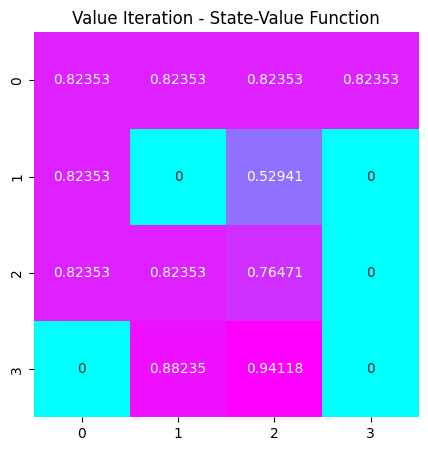


 Optimal Policy:



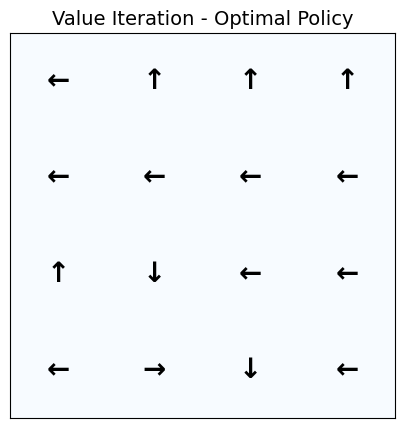


 Average Reward: 0.821


In [42]:
# Printing Results
print("Value Iteration")
print(f"Iterations: {iters_vi}")
print("Optimal Value Function:\n")
# رسم heatmap برای تابع ارزش
plot_value_function(V_vi, title="Value Iteration - State-Value Function")
print("\n Optimal Policy:\n")
# نمایش سیاست بهینه
policy_vi_grid = format_policy(policy_vi)
plot_policy(policy_vi_grid, title="Value Iteration - Optimal Policy")
print("\n Average Reward:", avg_reward_vi)


<h1>Printing Results for Policy Iteration<h1>
<p>This section prints the results of the Policy Iteration algorithm, including the number of iterations, the optimal value function, the optimal policy, and the average reward obtained by the policy.
<p>


Policy Iteration
Iterations: 3
Optimal Value Function:



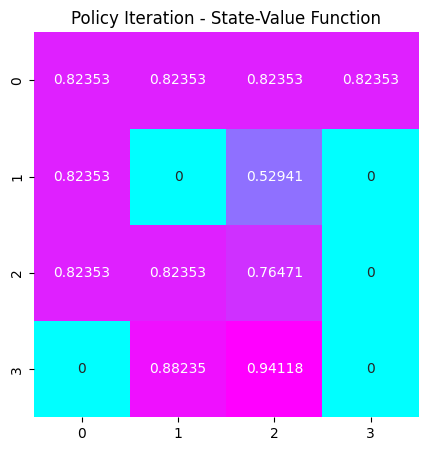


 Optimal Policy:



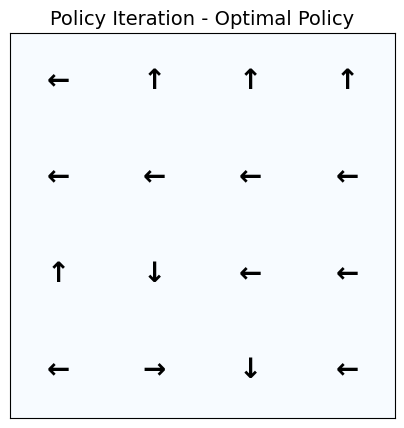


 Average Reward: 0.832


In [43]:
# Printing Results
print("Policy Iteration")
print(f"Iterations: {iters_pi}")
print("Optimal Value Function:\n")
# رسم heatmap برای تابع ارزش
plot_value_function(V_pi, title="Policy Iteration - State-Value Function")

print("\n Optimal Policy:\n")
# نمایش سیاست بهینه
policy_pi_grid = format_policy(policy_pi)
plot_policy(policy_pi_grid, title="Policy Iteration - Optimal Policy")
print("\n Average Reward:", avg_reward_pi)
